# Calisthenics Skills Pose Estimation
## Antonio Finocchiaro's progress diary

The purpose of this notebook is to track my progression and some thoughts about what I'm working for my thesis in CS followed by the Professor : Antonino Furnari.

The goal of this project is to create a sort of pipeline composed by two main sections to predict the various Calisthenics skills from a video and to count the seconds of the holds.
I decided to split this process in the first section, about Pose Estimation, made with Openpose model and the second one about the Classifier Neural Network to predict the video.
The building of the datasets will be in the first part. They'll be ready for the second one in a few months.

# <font color = green> 24/12/2022
<font color = black>
I worked in the last two days on my Openpose scripts, some codes to automatize some process and etc..
Starting from the skills I decided to identify : 

+ Planche (pl)
+ Front lever (fl)
+ One Arm Front Lever (oafl)
+ Iron Cross (ic)
+ Maltese (mal)
+ One Arm Handstandm (oahs)
+ Back Lever (bl)
+ Human Flag (hf)

I'll take soon the decision to include the *Victorian* or the *Front Lever touch* due to the similarity between them. 
The name closed in the bracket is the *id_skill* I'll use on the datasets to identify a skill.

# Openpose on Google Colab

Recently, I found a way to use Openpose on Colab without install it every time I change runtime or after the refreshing time of 12 hours. 
I installed Openpose on my google drive acccount (antosw2000@gmail.com) and everytime I open Colab I have to follow these steps : 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

I mount drive and copy the openpose directory to the "home"

In [ ]:
%cp -R /content/drive/MyDrive/openPose/openpose /content/

I reinstall the dependencies : 

In [ ]:
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

I change the permission of the build directory to make the system access the /build/examples/openpose/ folder  

In [ ]:
!chmod -R 777 build/

And today morning, I wrote the following code, to loop on a drive folder containing the video, process every video with some flags and then, put them in their specific folder : 

In [ ]:
# Specifica la cartella contenente i file video

import os

video_dir="/content/drive/MyDrive/datasetRaw/video_to_render/"

# Cicla attraverso tutti i file video nella cartella

for video_file in os.listdir(video_dir):
    
    # Esegui un'operazione su ogni file video (ad esempio, riprodurlo)
    #!echo "$(basename "$video_file")"

    video_name = video_file.split(".")[0]
    
    !mkdir -p /content/drive/MyDrive/datasetRaw/json_frames/$video_name    
        
    video_path = "/content/drive/MyDrive/datasetRaw/video_to_render/"+video_file
    json_output_path = "/content/drive/MyDrive/datasetRaw/json_frames/"+video_name+"/"
    video_output_path = "/content/drive/MyDrive/datasetRaw/out_video/"+video_file

    !./build/examples/openpose/openpose.bin \
    -keypoint_scale 3\
    --model_pose BODY_25B \
    --video {video_path} \
    --write_json {json_output_path} --display 0 \
    --number_people_max 1 \
    --write_video {video_output_path}

I decided to use the following flag :  `-keypoint_scale 3` to normalize the (x,y) keypoints couple to from file format to [0,1]. I'm using the model *BODY_25B* to have better accuracy than the COCO one. BODY_25B has 25 keypoints and they are the following : 

+ 0: 'Nose'
+ 1: 'LEye'
+ 2: 'REye'
+ 3: 'LEar'
+ 4: 'REar'
+ 5: 'LShoulder' 
+ 6: 'RShoulder'
+ 7: 'LElbow'
+ 8: 'RElbow'
+ 9: 'LWrist'
+ 10: 'RWrist'
+ 11: 'LHip'
+ 12: 'RHip'
+ 13: 'LKnee'
+ 14: 'RKnee'
+ 15: 'LAnkle'
+ 16: 'RAnkle'
+ 17: 'UpperNeck'
+ 18: 'HeadTop'
+ 19: 'LBigToe'
+ 20: 'LSmallToe'
+ 21: 'LHeel'
+ 22: 'RBigToe'
+ 23: 'RSmallToe'
+ 24: 'RHeel'

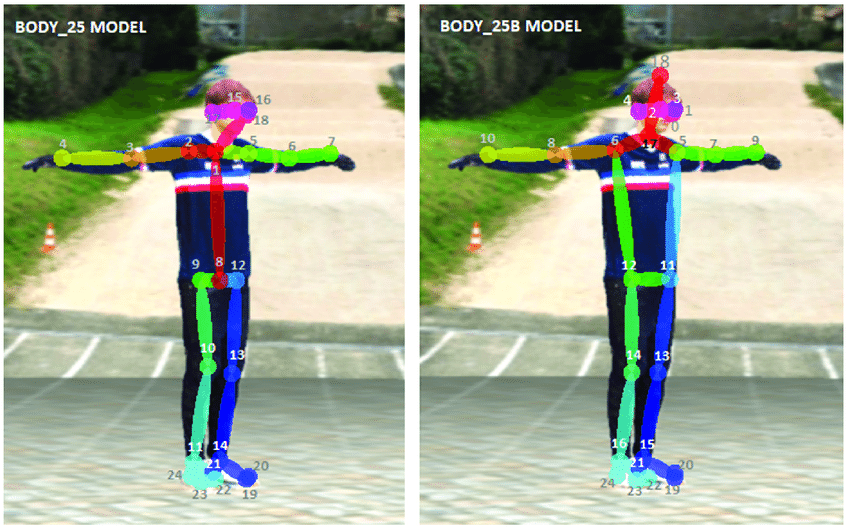

This is the comparative between the two models.

I tested the code in the previous cell and it worked! I am afraid about the usage that I can do on Colab, but I think to use it carefully and not so often; 
like rendering 10 videos a time. 

# Scripts to automize some processes

Then, having a google drive folder named "/datasetRaw/json_frames/" cointaining the folder of each video (with all keypoints inside); i worked with Google Drive API to make a script that download all the folders containing the keypoints in a local folder :  

In [ ]:
from Google import Create_Service
import os
import io 
from googleapiclient.http import MediaIoBaseDownload
import google.auth
import googleapiclient.discovery
import googleapiclient.errors
import shutil

CLIENT_SECRET_FILE = 'client_secret_GoogleCloud.json'
API_NAME = 'drive'
API_VERSION = 'v3'
SCOPES = ['https://www.googleapis.com/auth/drive']

service = Create_Service(CLIENT_SECRET_FILE, API_NAME, API_VERSION, SCOPES)

#print(dir(service))

parent_folder_id = '1Hu7Oxk82OvpCXmzK-3A2BttWw_us88ow'
local_directory = '/home/coloranto/Desktop/tesi/prova_script_keypoints/all_video_keypoints/'


# Recursively download the contents of the parent folder
def download_folder(folder_id, local_path):
    # Query for the list of files and folders in the current folder
    query = f"'{folder_id}' in parents and trashed = false"
    results = service.files().list(q=query, fields="nextPageToken, files(id, name, mimeType)").execute()
    items = results.get("files", [])
    # Download each file and recursively call this function for each folder
    for item in items:
        file_id = item['id']
        file = service.files().get(fileId=file_id).execute()
        file_name = file['name']
        if 'folder' in file['mimeType']:
            # Recursively call this function for the folder
            new_local_path = f'{local_path}/{file_name}'
            os.makedirs(new_local_path, exist_ok=True)
            download_folder(file_id, new_local_path)
        else:
            # Download the file
            print(f'Downloading file: {local_path}/{file_name}')
            request = service.files().get_media(fileId=file_id)
            fh = io.BytesIO()
            downloader = googleapiclient.http.MediaIoBaseDownload(fh, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()
            fh.seek(0)
            # Save the file to the local directory
            with open(f'{local_path}/{file_name}', 'wb') as f:
                f.write(fh.read())

# Create the local directory and start the recursive download
os.makedirs(local_directory, exist_ok=True)
download_folder(parent_folder_id, local_directory)

Google is a .py file I found to resolute the problems with authentication. 

In [ ]:
import pickle
import os
from google_auth_oauthlib.flow import Flow, InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from google.auth.transport.requests import Request


def Create_Service(client_secret_file, api_name, api_version, *scopes):
    print(client_secret_file, api_name, api_version, scopes, sep='-')
    CLIENT_SECRET_FILE = client_secret_file
    API_SERVICE_NAME = api_name
    API_VERSION = api_version
    SCOPES = [scope for scope in scopes[0]]
    print(SCOPES)

    cred = None

    pickle_file = f'token_{API_SERVICE_NAME}_{API_VERSION}.pickle'
    # print(pickle_file)

    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as token:
            cred = pickle.load(token)

    if not cred or not cred.valid:
        if cred and cred.expired and cred.refresh_token:
            cred.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRET_FILE, SCOPES)
            cred = flow.run_local_server()

        with open(pickle_file, 'wb') as token:
            pickle.dump(cred, token)

    try:
        service = build(API_SERVICE_NAME, API_VERSION, credentials=cred)
        print(API_SERVICE_NAME, 'service created successfully')
        return service
    except Exception as e:
        print('Unable to connect.')
        print(e)
        return None

def convert_to_RFC_datetime(year=1900, month=1, day=1, hour=0, minute=0):
    dt = datetime.datetime(year, month, day, hour, minute, 0).isoformat() + 'Z'
    return dt

I tested it and it works! By the way it has a big issue in terms of speed, the download speed is about 1 file/sec. This mean that to download a folder (representing a video) with about 150 json files, he'll need : 150 sec.
It has been a nice way to work with Google Drive API but I have to find a better solution in term of speed. 

Currently doing it manually, will drastically reduce the timing!

Then, between yesterday afternoon and today's one, I realized this code to do the following steps : 
+ Create a new .csv document and putting in it the first row containing 75 keypoints (x0,y0,c0,x1,y1,c1...) + 3 features : 'nome_video', 'frame_video', 'skill_id'
+ Extracting all the keypoints from the folder that I created with the previous script. Inside of them there are all the video keypoints, took by Openpose. 
+ Putting the .csv document created and extracted from the file name 2 features : 
    + from : 'flag1_000000000085_keypoints.json' I extracted the 'nome_video' : flag1 and the 'frame_video' : 85
    + the last feature I need is the id_skill, used to train later on this dataset. It take this information looping on another dataset I created : 


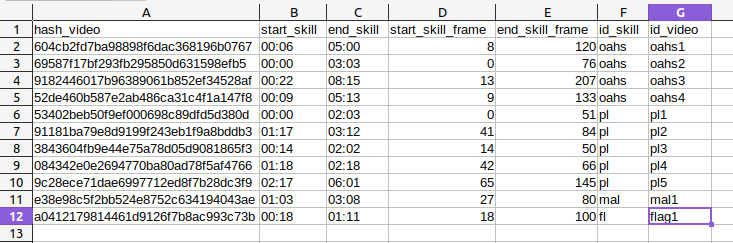

I compare the following nome_video and frame_video with all the rows present in this dataset and : 
if the nome_video is equal to the nome_video of the actual row and the frame_video is contained in the interval [start_skill_frame, end_skill_frame] I extract the skill_id and put it in the .csv I was creating. If the timeframe it's not contained in it, I'll use a generic label to identify the absence of skill : "null_skill", it will have 0 value on the final count.

This is the script I wrote : 

In [ ]:
import json
import csv
import glob
import re


with open('dataset.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['NoseX', 'NoseY', 'NoseC',
                                'LEyeX', 'LEyeY', 'LEyeC',
                                'REyeX', 'REyeY', 'REyeC',
                                'LEarX', 'LEarY', 'LEarC',
                                'REarX', 'REarY', 'REarC',
                                'LShoulderX', 'LShoulderY', 'LShoulderC',
                                'RShoulderX', 'RShoulderY', 'RShoulderC',
                                'LElbowX', 'LElbowY', 'LElbowC',
                                'RElbowX', 'RElbowY', 'RElbowC',
                                'LWristX', 'LWristY', 'LWristC',
                                'RWristX', 'RWristY', 'RWristC',
                                'LHipX', 'LHipY', 'LHipC',
                                'RHipX', 'RHipY', 'RHipC',
                                'LKneeX', 'LKneeY', 'LKneeC',
                                'RKneeX', 'RKneeY', 'RKneeC',
                                'LAnkleX', 'LAnkleY', 'LAnkleC',
                                'RAnkleX', 'RAnkleY', 'RAnkleC',
                                'UpperNeckX', 'UpperNeckY', 'UpperNeckC',
                                'HeadTopX', 'HeadTopY', 'HeadTopC',
                                'LBigToeX', 'LBigToeY', 'LBigToeC',
                                'LSmallToeX', 'LSmallToeY', 'LSmallToeC',
                                'LHeelX', 'LHeelY', 'LHeelC',
                                'RBigToeX', 'RBigToeY', 'RBigToeC',
                                'RSmallToeX', 'RSmallToeY', 'RSmallToeC',
                                'RHeelX', 'RHeelY', 'RHeelC',
                                'nome_video', 'frame_video', 'skill_id'])
    


#order alfabetically the folder
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

#loop on all json file in the folder
for i, folder in enumerate(glob.glob("./all_video_keypoints/*")):
    
    print("folder: ", folder)

    folder = natural_sort(glob.glob(folder + "/*"))
    
    for file in folder:
        
        #print(file)

        #read the json file
        with open(file) as f:
            data = json.load(f)
    

        if data["people"] == []:
            continue

        keypoints = data["people"][0]["pose_keypoints_2d"]
        
        name = file.split("/")[-1]
        name = name.split("_")
        nome_video = name[0]
    
        #print("nome_video vale: ", nome_video)

        #extracting the frame number without the 0 at the beginning
        frame_video = name[1]
        frame_video = frame_video.lstrip("0")
        if frame_video == "":
            frame_video = 0

        frame_video = int(frame_video)

        keypoints.append(nome_video)
        keypoints.append(frame_video)
    

        with open('dataset_video.csv', 'r') as f:
            reader = csv.reader(f)
            next(reader)
            sem = False
            for row in reader: 
                #print(row)


                #print("Compare ", nome_video, " with ", row[6])
                if nome_video == row[6] and frame_video >= int(row[3]) and frame_video <= int(row[4]):
                    #print("Sono uguali")
                    keypoints.append(row[6])
                    sem = True
                    break                
            
            if sem == False:
                keypoints.append("null_skill")

            
            print(keypoints)
        #write the keypoints in the csv file
        with open('dataset.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(keypoints)
            
#close the csv file
f.close()



I tested it and it works! This is the dataset.csv I obtain in output : 

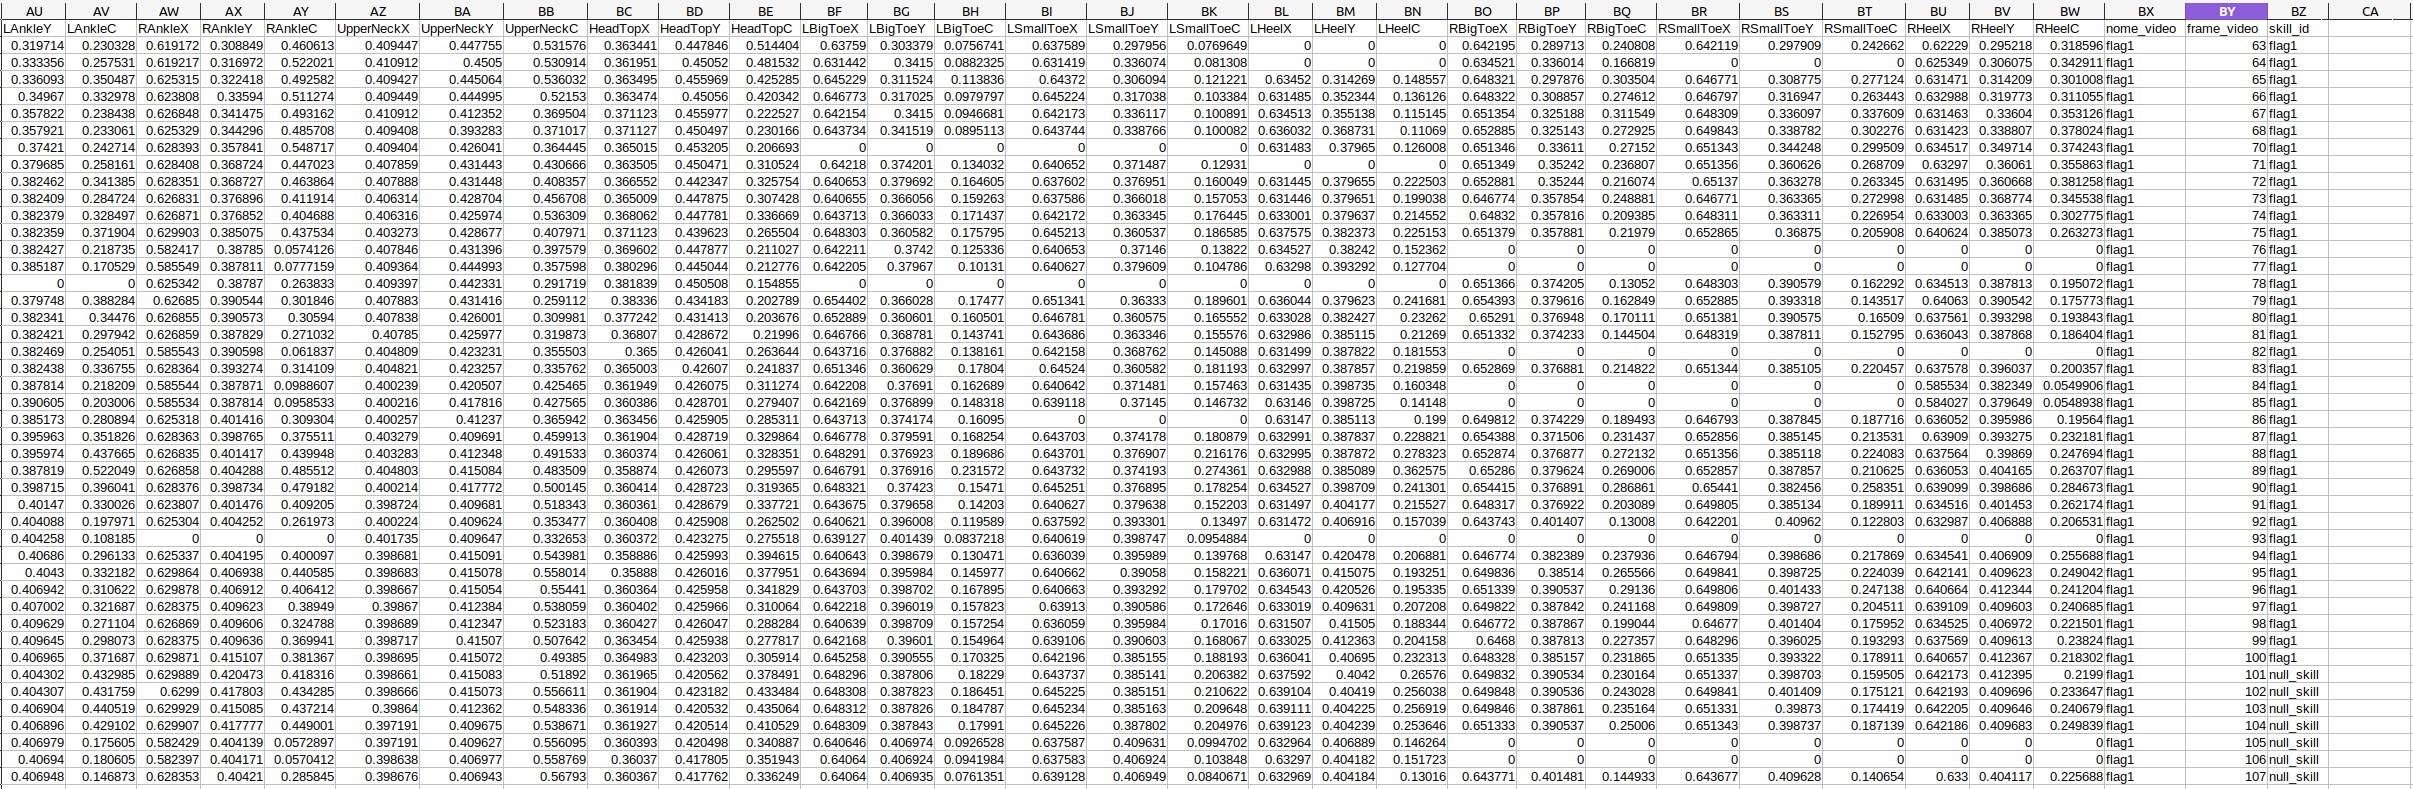

All the rows are the keypoints extracted, all the columns are the feature (78 in total). 
As we can see, the 'nome_video' column contain the indentifier of the video, 'frame_video' cointain the frame, 'skill_id' represent the **ground truth label**. 

NB : some frames are missing, this is voluntary, caused to the fact that in the video there are some frames with 0 keypoints; in this case the whole row will have all keypoints value to 0. This is a redundant data!

All the features are included between 0 and 1, it's a normalization to uniform the data. 

To build the video dataset, I am using a video editor software called **Kdenlive**, it's very easy to use and I render all videos with 960x540px resolution.
I find this resolution the best trade off between quality and compression, it's a 16:9 format, between the 1280x720 format and the 720x480 one.
All videos has 24 fps, no audio track and a hash value related. 

I am collecting them in a specific folder : 

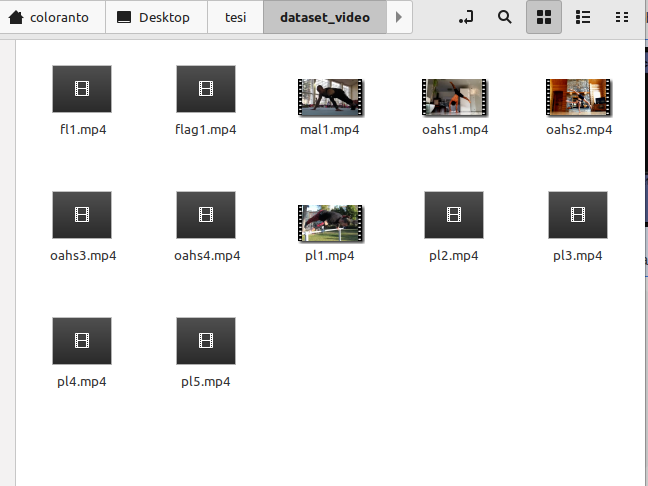

I know.. they are still only 12 videos but.. I'll increase them gradually over time!
My actually goal is to reach about 400-450 total video.

I had to resize this cause Openpose has serious difficult to detect the athlete if there are other people in the video and.. in lots of video, not all body part are present. 

These features, will make my job harder :(

I have lots of other info like all the integral video, all the kdenlive projects etc.. I'll find the best organization in few days. 
All the future updates and thoughts will be present on this notebook. I hope to go on collecting as more video as I can in the future weeks.
That's all, Merry Christmas! :)